# Test UMAP implementation

In [1]:
from cellarium.ml.models import SubsampledApproximateUMAP
from cellarium.ml.core import CellariumModule
from cellarium.ml.utilities.data import collate_fn
from cellarium.ml.core import CellariumAnnDataDataModule
from cellarium.ml.data import DistributedAnnDataCollection
from cellarium.ml.utilities.data import AnnDataField, densify

import lightning.pytorch as pl
import torch
import numpy as np
import anndata
import scanpy as sc
from umap import UMAP

import os

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [55]:
adata = anndata.read_h5ad('../data/pbmc_count.h5ad')
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'

In [56]:
adata.obs['batch'].value_counts()

batch
10X               10393
Oetjen_U           3668
Freytag            3347
Oetjen_P           3243
Oetjen_A           2535
Sun_sample4_TC     2387
Sun_sample3_TB     2322
Sun_sample2_KC     2175
Sun_sample1_CS     1704
Name: count, dtype: int64

In [57]:
desired_batch_size = 1024

keepers = []

for batch in adata.obs['batch'].unique():
    adata_batch = adata[adata.obs['batch'] == batch]
    n = int(np.floor(adata_batch.shape[0] / desired_batch_size))
    names = set(adata_batch.obs_names)
    for i in range(n):
        to_add = np.random.choice(np.array(list(names)), desired_batch_size, replace=False)
        keepers.append(to_add)
        names = names - set(to_add)

len(keepers)

28

In [58]:
inds_to_keep = np.hstack(np.array(keepers)[np.random.permutation(len(keepers))])
adata[inds_to_keep]

View of AnnData object with n_obs × n_vars = 28672 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'

In [59]:
# make sure all 256 minibatches have only one batch present (if traversed in order)

for inds in np.array_split(np.arange(len(inds_to_keep)), len(inds_to_keep) / desired_batch_size):
    assert adata[inds_to_keep][inds].obs['batch'].nunique() == 1

In [60]:
adata[inds_to_keep].copy().write(f'../data/pbmc_count_{desired_batch_size}_batch_size_partitioned_batch.h5ad')

In [61]:
class BoringDataset(torch.utils.data.Dataset):
    """A simple dataset for testing purposes."""

    def __init__(self, data: np.ndarray, var_names: np.ndarray | None = None) -> None:
        self.data = data
        self.var_names = var_names

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> dict[str, np.ndarray]:
        data = {"x_ng": self.data[idx, None]}
        if self.var_names is not None:
            data["var_names_g"] = self.var_names
        return data

In [62]:
def x_ng(n: int = 1000, g: int = 2000, k: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    z_nk = rng.standard_normal(size=(n, k), dtype=np.float32)
    z_nk[:n//2] += 1
    z_nk[:n//2, :g//2] += 0.5
    z_nk[n//2:] -= 1
    z_nk[-20:, -3:] += 10
    w_kg = rng.standard_normal(size=(k, g), dtype=np.float32)
    sigma = 0.6
    noise = sigma * rng.standard_normal(size=(n, g), dtype=np.float32)
    x_ng = z_nk @ w_kg + noise
    return x_ng

In [99]:
# batch_size = 2**12
batch_size = 1024

# x = x_ng()
# dataset = BoringDataset(
#     x,
#     np.array([f"gene_{i}" for i in range(x.shape[1])]),
# )

dm = CellariumAnnDataDataModule(
    DistributedAnnDataCollection(
        # "../data/pbmc_count.h5ad",
        f"../data/pbmc_count_{batch_size}_batch_size_partitioned_batch.h5ad",
        # shard_size=31_774,
        # shard_size=30_720,
        shard_size=28672,
        max_cache_size=1,
    ),
    # max_cache_size=2,
    batch_keys={
        "x_ng": AnnDataField(attr="X", convert_fn=densify),
        "var_names_g": AnnDataField(attr="var_names"),
    },
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    drop_last=False,
    num_workers=4,
)
dm.setup()

# train_loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     collate_fn=collate_fn,
# )

In [100]:
adata = dm.dadc.adatas[0].adata
adata.obsm['X_umap'] = UMAP().fit_transform(adata.X)
adata

KeyboardInterrupt: 

In [ ]:
adata.obs['batch'].value_counts()

batch
10X               10240
Freytag            3072
Oetjen_P           3072
Oetjen_U           3072
Oetjen_A           2048
Sun_sample2_KC     2048
Sun_sample3_TB     2048
Sun_sample4_TC     2048
Sun_sample1_CS     1024
Name: count, dtype: int64

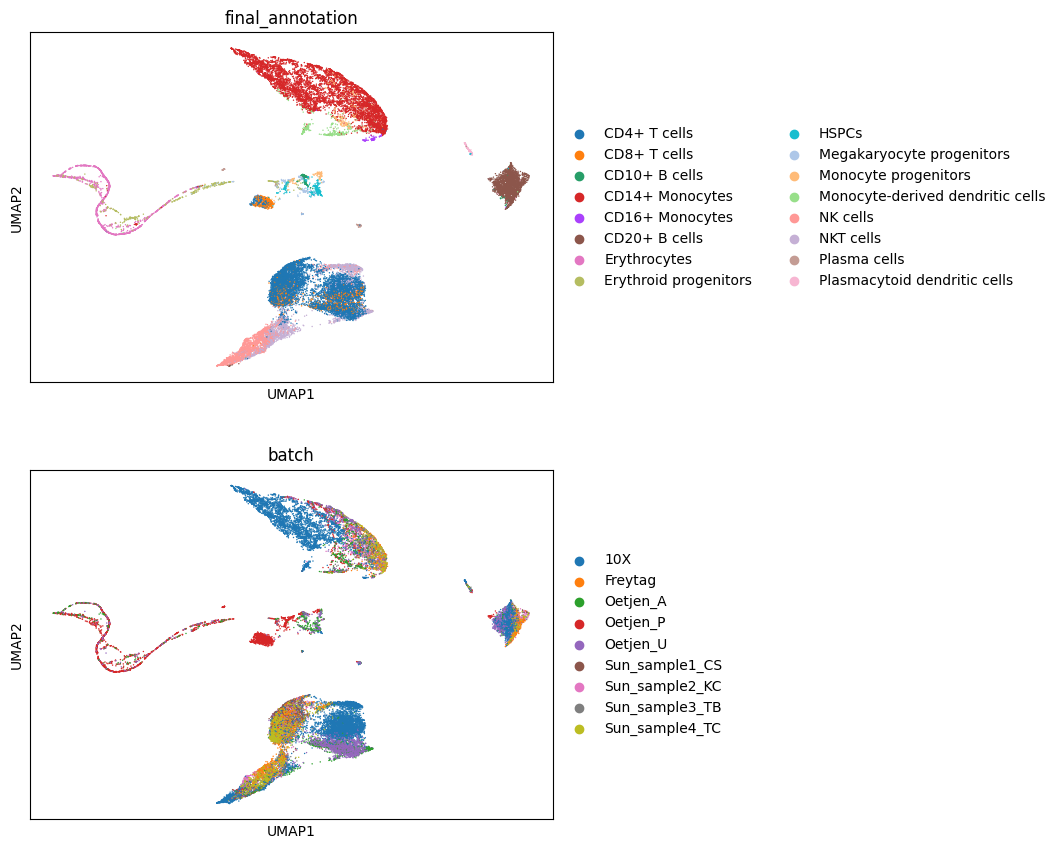

In [97]:
sc.pl.embedding(adata, basis='umap', color=['final_annotation', 'batch'], ncols=1)

In [101]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(adata.shape[1], 128),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Linear(32, 2),
)

In [102]:
class EncoderUMAP(torch.nn.Module):
    def __init__(self, encoder: torch.nn.Module) -> None:
        super().__init__()
        self.encoder = encoder

    def forward(self, x_ng: torch.Tensor) -> torch.Tensor:
        return self.encoder(x_ng)

    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(layer.weight)

In [103]:
max_steps = 500

devices = int(os.environ.get("TEST_DEVICES", "1"))

umap = SubsampledApproximateUMAP(
    encoder=EncoderUMAP(encoder),
    var_names_g=adata.var_names,
    n_components=2,
    n_neighbors=5,
)
module = CellariumModule(
    model=umap,
    optim_fn=torch.optim.AdamW,
    optim_kwargs={"lr": 5e-3},
    scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
    scheduler_kwargs={"max_lr": 2e-2,
                      "total_steps": max_steps},
)
# trainer
trainer = pl.Trainer(
    accelerator="cpu",
    devices=devices,
    max_steps=max_steps,
    log_every_n_steps=1,
    callbacks=[pl.callbacks.LearningRateMonitor()],
)
# fit
trainer.fit(module, train_dataloaders=dm.train_dataloader())

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name     | Type              | Params
-----------------------------------------------
0 | pipeline | CellariumPipeline | 522 K 
-----------------------------------------------
522 K     Trainable params
0         Non-trainable params
522 K     Total params
2.092     Total estimated model params size (MB)
/home/sfleming/cellarium-ml/cellarium/ml/utilities/da

Training: |          | 0/? [00:00<?, ?it/s]

/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserW

In [104]:
umap

SubsampledApproximateUMAP(encoder=EncoderUMAP(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=32, out_features=2, bias=True)
  )
), var_names_g=array(['TCL1A', 'IGLL5', 'FGFBP2', ..., 'SARDH', 'SEPT10', 'TJP2'],
      dtype=object))

In [105]:
adata.obsm['X_approx_umap'] = umap.predict(x_ng=torch.from_numpy(np.array(adata.X.todense())), var_names_g=adata.var_names).detach().numpy()

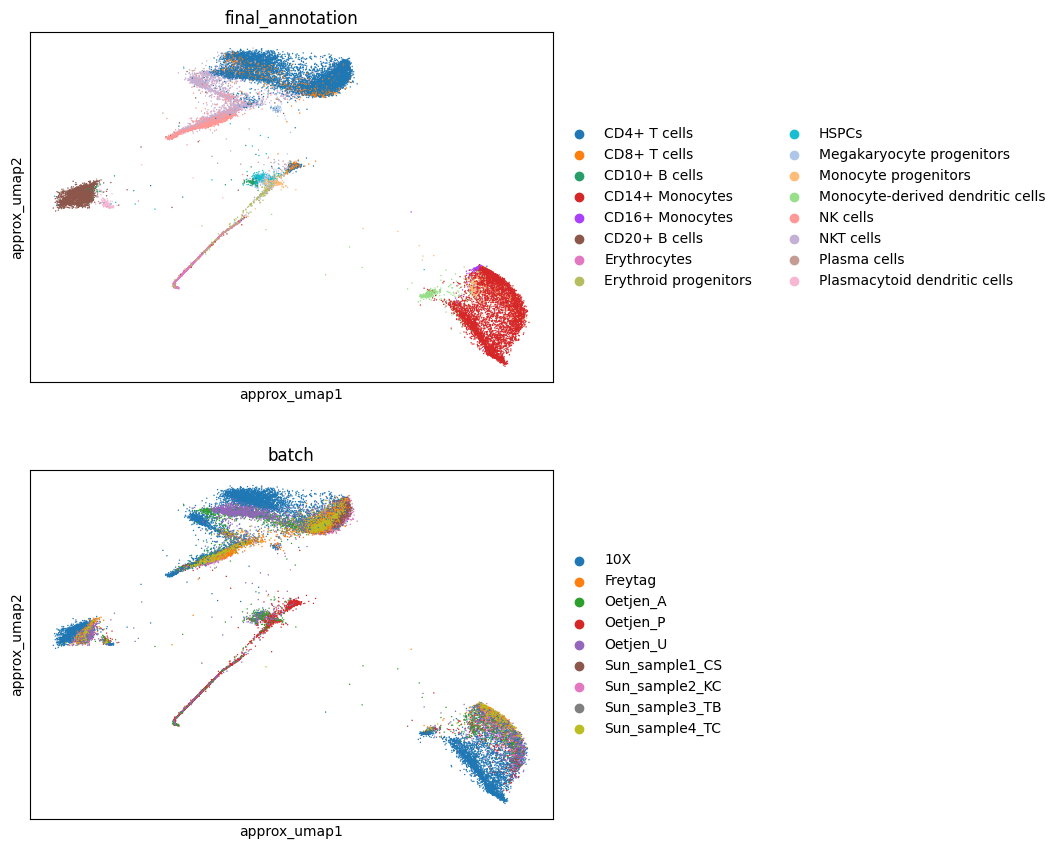

In [106]:
sc.pl.embedding(adata, basis='approx_umap', color=['final_annotation', 'batch'], ncols=1)